In [1]:
import torch
import torch.nn as nn


In [2]:
#W8A16 Linear Layer

def linear_quantize(tensor, dtype=torch.int8):
    r_min = tensor.min().item()
    r_max = tensor.max().item()
    
    q_min = torch.iinfo(dtype).min
    q_max = torch.iinfo(dtype).max
    
    scale = (r_max - r_min) / (q_max - q_min)
    zero_point = torch.round(torch.tensor(q_min - (r_min / scale))).to(torch.int8).item()

    zero_point = torch.clamp_(torch.tensor(zero_point), min=q_min, max=q_max)
    
    quantized_tensor = torch.round(tensor / scale + zero_point)
    quantized_tensor = torch.clamp_(quantized_tensor, min=q_min, max=q_max).to(torch.int8)
    return scale, zero_point.item(), quantized_tensor

def channel_linear_quantize(tensor, dim=0, dtype=torch.int8):
    scales = torch.zeros(tensor.size(dim))
    zero_pts = torch.zeros(tensor.size(dim), dtype=torch.int8)


    quantized_tensor = torch.zeros_like(tensor, dtype=dtype)

    for i in range(tensor.size(dim)):
        scales[i], zero_pts[i], quant = linear_quantize(tensor.select(dim, i), dtype=dtype)

        if dim == 1:
            quantized_tensor[:, i] = quant
        else:
            quantized_tensor[i, :] = quant
            
    if (dim == 0):
        scales = scales.view(scales.shape[dim], -1)
        zero_pts = zero_pts.view(zero_pts.shape[dim], -1)
    elif dim == 1:
        
        scales = scales.view(-1, scales.shape[0])
        zero_pts = zero_pts.view(-1, zero_pts.shape[0])
        
    # quantized_tensor = torch.clamp_(torch.round(tensor / scales + zero_pts), 
    #                                   min=torch.iinfo(dtype).min, 
    #                                   max=torch.iinfo(dtype).max).to(torch.int)
    return scales, zero_pts, quantized_tensor

In [3]:
torch.randn(3,1)

tensor([[ 1.7568],
        [-0.8574],
        [ 1.5602]])

In [4]:

class W8A16LinearLayer(nn.Module):
    def __init__(self, in_features=4, out_features=4, dtype=torch.float32, bias=False):
        super(W8A16LinearLayer, self).__init__()
        self.register_buffer('int8_weights', torch.randint(torch.iinfo(torch.int8).min, torch.iinfo(torch.int8).max, (in_features, out_features), dtype=torch.int8))
        self.register_buffer('scales', torch.randn(out_features, 1, dtype=torch.float32))
        self.register_buffer('zero_point', torch.randint(torch.iinfo(torch.int8).min, torch.iinfo(torch.int8).max, (out_features, 1), dtype=torch.int8))
        self.dtype = dtype
        if bias:
            self.register_buffer('bias', torch.empty(out_features, dtype=dtype))
        else:
            self.bias = None


    def quantize(self, x):
        x = x.to(torch.float32)
        scales, zero_pts, quant_weights = channel_linear_quantize(x, dim=0)
        #    Use .copy_() for an in-place update.
        # print(scales.shape)
        # print(zero_pts.shape)
        # print(self.scales.shape)
        # print(self.zero_point.shape)
        self.int8_weights.copy_(quant_weights)
        self.scales.copy_(scales) 
        self.zero_point.copy_(zero_pts)
        return scales, zero_pts, quant_weights
    
    def linear_dequantize(self, scales, zero_pts, quant):
        return scales * (quant.float() - zero_pts)

    def forward(self, x, dtype=torch.bfloat16):
        dequant = self.linear_dequantize(self.scales, self.zero_point, self.int8_weights)
        out = torch.matmul(x.to(dtype), dequant.to(dtype)) + (self.bias if self.bias is not None else torch.tensor(0.0).to(dtype))
        return out

In [5]:
def linear_dequantize(scale, zero_point, quantized_tensor):
    return scale * (quantized_tensor.float() - zero_point)


In [6]:
# Corrected test code
quantized_ly = W8A16LinearLayer()

# Store original weights before quantization
original_weights = quantized_ly.int8_weights.clone()
# print(original_weights.dtype)

# Quantize the weights
scales, zero_pts, quant = quantized_ly.quantize(original_weights)

# Dequantize to check reconstruction quality
dequantized_weights = quantized_ly.linear_dequantize(scales, zero_pts, quant)

# Calculate MSE between original and reconstructed weights
weight_mse = (dequantized_weights - original_weights).pow(2).mean()
print(f"Weight reconstruction MSE: {weight_mse}")

# For forward pass comparison
test_input = torch.randn(1, 4, dtype=torch.bfloat16)  # Batch size 1
test_linear = nn.Linear(4, 4, bias=False, dtype=torch.bfloat16)
test_linear_out = test_linear(test_input)

original_weights_float = test_linear.weight.data
scales, zero_pts, quant = channel_linear_quantize(original_weights_float, dim=0)
dequantized_weights = linear_dequantize(scales, zero_pts, quant)
test_linear.weight.data = dequantized_weights.to(torch.bfloat16)
test_out_dequan = test_linear(test_input)
out = quantized_ly.forward(test_input, dtype=torch.bfloat16)
# print(out)
print((test_out_dequan - test_linear_out).square().mean())  # Should be close to zero if weights are well reconstructed

Weight reconstruction MSE: 0.046443648636341095
tensor(2.4214e-07, dtype=torch.bfloat16, grad_fn=<MeanBackward0>)


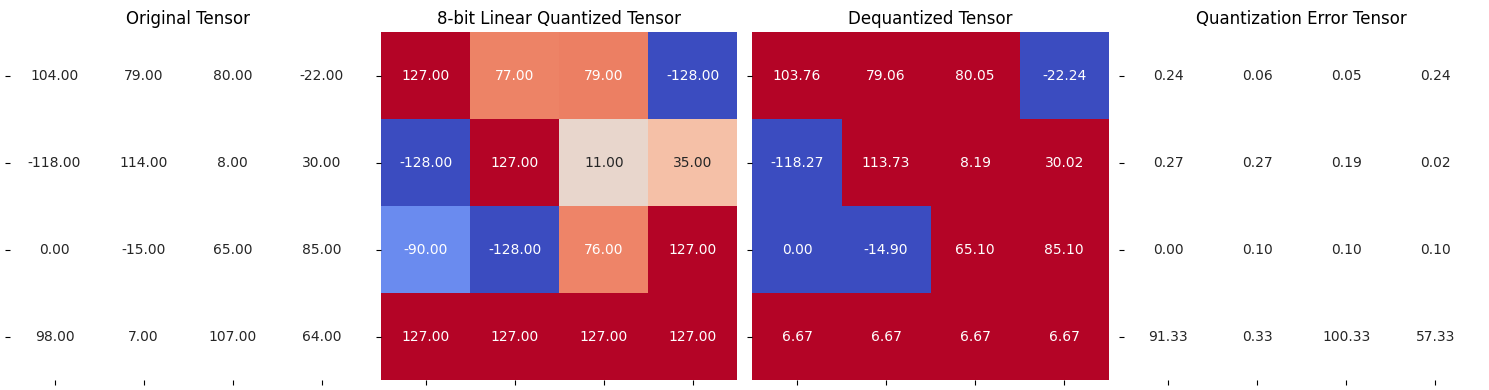

In [8]:
from helper import plot_quantization_errors

plot_quantization_errors(original_weights, quant, dequantized_weights)

In [13]:
def replace_linear_with_target_and_quantize(module, 
                               target_class, module_name_to_exclude):
    for name, child in module.named_children():
        if isinstance(child, nn.Linear) and not \
        any([x == name for x in module_name_to_exclude]):
            old_bias = child.bias
            old_weight = child.weight

            new_module = target_class(child.in_features, 
                                      child.out_features, 
                                      old_bias is not None, 
                                      child.weight.dtype)
            setattr(module, name, new_module)

            getattr(module, name).quantize(old_weight)
            
            if old_bias is not None:
              getattr(module, name).bias = old_bias
        else:
            # Recursively call the function for nested modules
            replace_linear_with_target_and_quantize(child, 
                     target_class, module_name_to_exclude)

In [14]:
class DummyModel(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.emb = torch.nn.Embedding(1, 1)
    # Try with bias
    self.linear_1 = nn.Linear(1, 1)
    # Try without bias
    self.linear_2 = nn.Linear(1, 1, bias=False)
    # Lm prediction head
    self.lm_head = nn.Linear(1, 1, bias=False)

In [ ]:
model = DummyModel()
replace_linear_with_target_and_quantize(model, W8A16LinearLayer, ["lm_head"])
print(model)